In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%pip install tqdm
%pip install wandb --upgrade

In [3]:
import wandb
import os
import torch
from PIL import Image
from torchvision import transforms
import random
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch import nn
from tqdm import tqdm
from torch.utils.data import DataLoader
import numpy as np
import torchvision.datasets as datasets
from scipy.stats import gaussian_kde
from scipy.stats import norm
from random import randint
import torch.distributions as dist
import math

In [4]:
wandb.login(key='')

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"


ex2
nums of EM: 3
Channel : 224  pixels : 2500


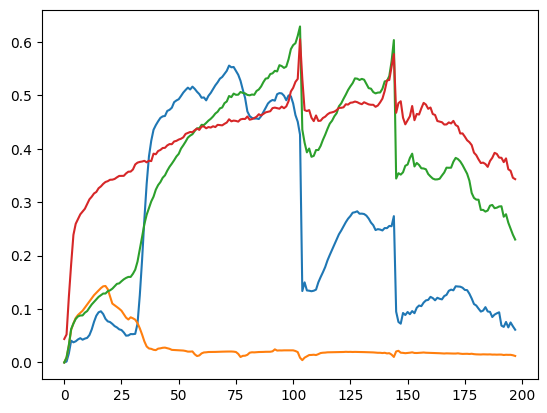

In [6]:
import numpy as np
import scipy.io as scio


def loadhsi(case):
    '''
    :input: case: for different datasets,
                 'toy' and 'usgs' are synthetic datasets
    :return: Y : HSI data of size [Bands,N]
             A_ture : Ground Truth of abundance map of size [P,N]
             P : nums of endmembers signature
    '''

    if case == 'ridge':
        file = '/content/drive/MyDrive/dataset/JasperRidge2_R198.mat'
        data = scio.loadmat(file)
        Y = data['Y']  # (C,w*h)
        Y = np.reshape(Y,[198,100,100])

        for i,y in enumerate(Y):
            Y[i]=y.T
        Y = np.reshape(Y, [198, 10000])
        GT_file = '/content/drive/MyDrive/dataset/JasperRidge2_end4.mat'
        A_true = scio.loadmat(GT_file)['A']
        A_true = np.reshape(A_true, (4, 100, 100))
        for i,A in enumerate(A_true):
            A_true[i]=A.T
        if np.max(Y) > 1:
            Y = Y / np.max(Y)



    elif case == 'urban':
        file = '/content/drive/MyDrive/dataset/Urban_F210.mat'
        data = scio.loadmat(file)
        Y = data['Y']  # (C,w*h)

        GT_file = '/content/drive/MyDrive/dataset/end6_groundTruth.mat'
        A_true = scio.loadmat(GT_file)['A']
        if np.max(Y) > 1:
            Y = Y / np.max(Y)

    elif case == 'ex2':
        file = '/content/drive/MyDrive/dataset/data_ex2.mat'
        data = scio.loadmat(file)
        Y = data['r']
        # Y = Y.T
        A_true = data['alphas']
        A_true=A_true.reshape(3,50,50)




    P = A_true.shape[0]

    Y = Y.astype(np.float32)
    A_true = A_true.astype(np.float32)
    return Y, A_true, P

if __name__=='__main__':
    cases = ['ex2','ridge', 'urban']
    case = cases[0]

    Y, A_true, P = loadhsi(case)
    Channel = Y.shape[0]
    N = Y.shape[1]
    print(case)
    print('nums of EM:',P)
    print('Channel :',Channel, ' pixels :',N)

    GT_file = '/content/drive/MyDrive/dataset/JasperRidge2_end4.mat'
    M = scio.loadmat(GT_file)['M']

    from matplotlib import pyplot as plt
    plt.plot(M)
    plt.show()

In [16]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('Linear') != -1:
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0)


In [17]:
sweep_config = {
    'method': 'random'
    }

metric = {
    'name':'loss',
    'goal':'minimize'
}
sweep_config['metric']=metric

parameters_dict = {
    'z_dim': {
        'value':4},
    'num_epochs':{
        'value':200},
    'learning_rate':{
        'value':1e-3},
    }

sweep_config['parameters'] = parameters_dict

In [18]:
cases = ['ex2', 'ridge']
case = cases[1]
# load data
Y, A_true, P = loadhsi(case)
Channel = Y.shape[0]
N = Y.shape[1]
batchsz = N//10
Y = np.transpose(Y)
train_db = torch.tensor(Y)
train_db = torch.utils.data.TensorDataset(train_db)
train_db = torch.utils.data.DataLoader(train_db, batch_size=batchsz, shuffle=True)
sweep_config['parameters']['P'] = {'value': P}
sweep_config['parameters']['Channel'] = {'value': Channel}
sweep_config['parameters']['N'] = {'value': N}
sweep_config['parameters']['batchsz'] = {'value': batchsz}
print(sweep_config)

{'method': 'random', 'metric': {'name': 'loss', 'goal': 'minimize'}, 'parameters': {'z_dim': {'value': 4}, 'num_epochs': {'value': 200}, 'learning_rate': {'value': 0.001}, 'P': {'value': 4}, 'Channel': {'value': 198}, 'N': {'value': 10000}, 'batchsz': {'value': 1000}}}


In [10]:
sweep_id = wandb.sweep(sweep_config, project='bivariate self adapt PGMSU')
project='bivariate self adapt PGMSU'
folder_path=f"/content/drive/MyDrive/Colab Notebooks/FYP/Sweeps/{project}/{sweep_id}"
os.makedirs(folder_path)

Create sweep with ID: wyvwcxhy
Sweep URL: https://wandb.ai/b-shivashankar2735-vasavi-college-of-engineering/bivariate%20self%20adapt%20PGMSU/sweeps/wyvwcxhy


In [21]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as scio


def pca(X, d):
    N = np.shape(X)[1]
    xMean = np.mean(X, axis=1, keepdims=True)
    XZeroMean = X - xMean
    [U, S, V] = np.linalg.svd((XZeroMean @ XZeroMean.T) / N)
    Ud = U[:, 0:d]
    return Ud


def hyperVca(M, q):
    '''
    M : [p,N]
    '''
    L, N = np.shape(M)

    rMean = np.mean(M, axis=1, keepdims=True)
    RZeroMean = M - rMean
    U, S, V = np.linalg.svd(RZeroMean @ RZeroMean.T / N)
    Ud = U[:, 0:q]

    Rd = Ud.T @ RZeroMean
    P_R = np.sum(M ** 2) / N
    P_Rp = np.sum(Rd ** 2) / N + rMean.T @ rMean
    SNR = np.abs(10 * np.log10((P_Rp - (q / L) * P_R) / (P_R - P_Rp)))
    snrEstimate = SNR
    # print('SNR estimate [dB]: %.4f' % SNR[0, 0])
    # Determine which projection to use.
    SNRth = 18 + 10 * np.log(q)

    if SNR > SNRth:
        d = q
        # [Ud, Sd, Vd] = svds((M * M.')/N, d);
        U, S, V = np.linalg.svd(M @ M.T / N)
        Ud = U[:, 0:d]
        Xd = Ud.T @ M
        u = np.mean(Xd, axis=1, keepdims=True)
        # print(Xd.shape, u.shape, N, d)
        Y = Xd /  np.sum(Xd * u , axis=0, keepdims=True)

    else:
        d = q - 1
        r_bar = np.mean(M.T, axis=0, keepdims=True).T
        Ud = pca(M, d)

        R_zeroMean = M - r_bar
        Xd = Ud.T @ R_zeroMean
        # Preallocate memory for speed.
        # c = np.zeros([N, 1])
        # for j in range(N):
        #     c[j] = np.linalg.norm(Xd[:, j], ord=2)
        c = [np.linalg.norm(Xd[:, j], ord=2) for j in range(N)]
        # print(type(c))
        c = np.array(c)
        c = np.max(c, axis=0, keepdims=True) @ np.ones([1, N])
        Y = np.concatenate([Xd, c.reshape(1, -1)])
    e_u = np.zeros([q, 1])
    # print('*',e_u)
    e_u[q - 1, 0] = 1
    A = np.zeros([q, q])
    # idg - Doesntmatch.
    # print (A[:, 0].shape)
    A[:, 0] = e_u[0]
    I = np.eye(q)
    k = np.zeros([N, 1])

    indicies = np.zeros([q, 1])
    for i in range(q):  # i=1:q
        w = np.random.random([q, 1])

        # idg - Oppurtunity for speed up here.
        tmpNumerator = (I - A @ np.linalg.pinv(A)) @ w
        # f = ((I - A * pinv(A)) * w) / (norm(tmpNumerator));
        f = tmpNumerator / np.linalg.norm(tmpNumerator)

        v = f.T @ Y
        k = np.abs(v)

        k = np.argmax(k)
        A[:, i] = Y[:, k]
        indicies[i] = k

    indicies = indicies.astype('int')
    # print(indicies.T)
    if (SNR > SNRth):
        U = Ud @ Xd[:, indicies.T[0]]
    else:
        U = Ud @ Xd[:, indicies.T[0]] + r_bar

    return U, indicies, snrEstimate



In [22]:
EM, _, _ = hyperVca(Y.T, P)
EM = EM.T
EM = np.reshape(EM, [1, EM.shape[0], EM.shape[1]]).astype('float32')
EM = torch.tensor(EM).to(device)

In [23]:
seed=0
os.environ['PYTHONHASHSEED'] = str(seed)
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        if not torch.cuda.is_available():
            print('WARNING: You have a CUDA device, so you should probably run with --cuda')
        else:
            torch.cuda.manual_seed(seed)
            torch.cuda.manual_seed_all(seed)
    # torch.backends.cudnn.benchmark = False
    # torch.backends.cudnn.deterministic = True



In [24]:
import os
model_weights = '/content/drive/MyDrive/PGMSU_weight/'
output_path = '/content/drive/MyDrive/PGMSU_out/'
if not os.path.exists(output_path):
    os.makedirs(output_path)
if not os.path.exists(model_weights):
    os.makedirs(model_weights)
model_weights += 'PGMSU.pt'

In [25]:
from torch import nn
import torch
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class PGMSU(nn.Module):
    def __init__(self, P, Channel, z_dim):
        super(PGMSU, self).__init__()
        self.P = P
        self.Channel = Channel
        # encoder z  fc1 -->fc5
        self.fc1 = nn.Linear(Channel, 32 * P)
        self.bn1 = nn.BatchNorm1d(32 * P)

        self.fc2 = nn.Linear(32 * P, 16 * P)
        self.bn2 = nn.BatchNorm1d(16 * P)

        self.fc3 = nn.Linear(16 * P, 4 * P)
        self.bn3 = nn.BatchNorm1d(4 * P)

        self.fc4 = nn.Linear(4 * P, z_dim)
        self.fc5 = nn.Linear(4 * P, z_dim)

        # encoder a
        self.fc9 = nn.Linear(Channel, 32 * P)
        self.bn9 = nn.BatchNorm1d(32 * P)

        self.fc10 = nn.Linear(32 * P, 16 * P)
        self.bn10 = nn.BatchNorm1d(16 * P)

        self.fc11 = nn.Linear(16 * P, 4 * P)
        self.bn11 = nn.BatchNorm1d(4 * P)

        self.fc12 = nn.Linear(4 * P, 4 * P)
        self.bn12 = nn.BatchNorm1d(4 * P)

        self.fc13 = nn.Linear(4 * P, 1 * P)  # get abundance

        ### decoder
        self.fc6 = nn.Linear(z_dim, P * 4)
        self.bn6 = nn.BatchNorm1d(P * 4)

        self.fc7 = nn.Linear(P * 4, P * 64)
        self.bn7 = nn.BatchNorm1d(P * 64)

        self.fc8 = nn.Linear(P * 64, Channel * P)

    def encoder_z(self, x):
        h1 = self.fc1(x)
        h1 = self.bn1(h1)
        h1 = F.leaky_relu(h1, 0.00)

        h1 = self.fc2(h1)
        h1 = self.bn2(h1)
        h11 = F.leaky_relu(h1, 0.00)

        h1 = self.fc3(h11)
        h1 = self.bn3(h1)
        h1 = F.leaky_relu(h1, 0.00)

        mu = self.fc4(h1)
        log_var = self.fc5(h1)
        return mu, log_var

    def encoder_a(self, x):
        h1 = self.fc9(x)
        h1 = self.bn9(h1)
        h1 = F.leaky_relu(h1, 0.00)

        h1 = self.fc10(h1)
        h1 = self.bn10(h1)
        h1 = F.leaky_relu(h1, 0.00)

        h1 = self.fc11(h1)
        h1 = self.bn11(h1)
        h1 = F.leaky_relu(h1, 0.00)

        h1 = self.fc12(h1)
        h1 = self.bn12(h1)

        h1 = F.leaky_relu(h1, 0.00)
        h1 = self.fc13(h1)

        a = F.softmax(h1, dim=1)
        return a

    def reparameterize(self, mu, log_var):
        std = (log_var * 0.5).exp()
        eps = torch.randn(mu.shape, device=device)
        return mu + eps * std

    def decoder(self, z):
        h1 = self.fc6(z)
        h1 = self.bn6(h1)
        h1 = F.leaky_relu(h1, 0.00)

        h1 = self.fc7(h1)
        h1 = self.bn7(h1)
        h1 = F.leaky_relu(h1, 0.00)

        h1 = self.fc8(h1)
        em = torch.sigmoid(h1)
        return em

    def forward(self, inputs):
        mu, log_var = self.encoder_z(inputs)
        a = self.encoder_a(inputs)

        # reparameterization trick
        z = self.reparameterize(mu, log_var)
        em = self.decoder(z)

        em_tensor = em.view([-1, self.P, self.Channel])
        a_tensor = a.view([-1, 1, self.P])
        y_hat = a_tensor @ em_tensor
        y_hat = torch.squeeze(y_hat, dim=1)

        return y_hat, mu, log_var, a, em_tensor


In [26]:
import torch

def loss_function(y, y_hat, mu, log_var, em_tensor, EM, P, Channel):
    """
    Computes the different loss components for hyperspectral unmixing model.

    Parameters:
    - y: The input hyperspectral data (tensor)
    - y_hat: The predicted hyperspectral data (tensor)
    - mu: The mean of the latent space (tensor)
    - log_var: The log variance of the latent space (tensor)
    - em_tensor: The learned endmembers (tensor)
    - EM: The true endmembers (tensor)
    - P: Number of endmembers (integer)
    - Channel: Number of spectral channels (integer)

    Returns:
    - loss_rec: Reconstruction loss (tensor)
    - kl_div: KL divergence loss (tensor)
    - loss_vca: VCA loss (tensor)
    - loss_minvol: Minimum volume constraint loss (tensor)
    - loss_sad: Spectral Angle Divergence loss (tensor)
    """

    loss_rec = ((y_hat - y) ** 2).sum() / y.shape[0]


    kl_div = -0.5 * (log_var + 1 - mu ** 2 - log_var.exp())
    kl_div = kl_div.sum() / y.shape[0]
    kl_div = torch.max(kl_div, torch.tensor(0.2).to(y.device))  # KL balance (min 0.2)

    loss_vca = (em_tensor - EM).square().sum() / y.shape[0]

    # 4. Minimum volume constraint loss (loss_minvol)
    em_bar = em_tensor.mean(dim=1, keepdim=True)  # Mean across samples
    loss_minvol = ((em_tensor - em_bar) ** 2).sum() / y.shape[0] / P / Channel

    # 5. Spectral Angle Divergence loss (loss_sad)
    em_bar = em_tensor.mean(dim=0, keepdim=True)  # Mean across endmembers
    aa = (em_tensor * em_bar).sum(dim=2)  # Dot product between endmembers and their mean
    em_bar_norm = em_bar.square().sum(dim=2).sqrt()  # Norm of the mean endmember
    em_tensor_norm = em_tensor.square().sum(dim=2).sqrt()  # Norm of the endmembers

    sad = torch.acos(aa / (em_bar_norm + 1e-6) / (em_tensor_norm + 1e-6))  # SAD calculation
    loss_sad = sad.sum() / y.shape[0] / P  # Average SAD loss

    # Return individual losses
    return loss_rec, kl_div, loss_vca, loss_minvol, loss_sad


In [27]:
def fitness_func_post( lambda_kl, lambda_vol, lambda_sad, loss_rec, kl_div, loss_minvol, loss_sad,loss):
    """
    Compute the fitness value based on individual loss components.

    Parameters:
    - lambda_kl: Weight coefficient for KL divergence (float)
    - lambda_vol: Weight coefficient for minimum volume loss (float)
    - lambda_sad: Weight coefficient for SAD loss (float)
    - loss_rec: Reconstruction loss (tensor)
    - kl_div: KL divergence loss (tensor)
    - loss_minvol: Minimum volume constraint loss (tensor)
    - loss_sad: Spectral Angle Divergence loss (tensor)

    Returns:
    - fitness: The fitness value (tensor)
    """

    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Combine losses into a single loss value
    loss_new = loss_rec + lambda_kl * kl_div + lambda_vol * loss_minvol + lambda_sad * loss_sad

    # Fitness value is the inverse of the total loss
    fitness = 1 / loss_new

    return fitness.to(device)


In [28]:
def fitness_func_pre(lambda_kl,lambda_vca, loss_rec, kl_div, loss_vca):
    """
    Compute the fitness value based on individual loss components.

    Parameters:
    - lambda_kl: Weight coefficient for KL divergence (float)
    - lambda_vca: Weight coefficient for VCA loss (float)
    - loss_rec: Reconstruction loss (tensor)
    - kl_div: KL divergence loss (tensor)
    - loss_vca: VCA loss (tensor)

    Returns:
    - fitness: The fitness value (tensor)
    """

    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Combine losses into a single loss value
    loss_new = loss_rec + lambda_kl * kl_div + lambda_vca*loss_vca

    # Fitness value is the inverse of the total loss
    fitness = 1 / loss_new

    return fitness.to(device)


In [29]:
def selfadapt_SBX_lambda(pop_size, eta_kl, eta_vol, eta_sad, crossover_rate, mutation_rate,
                         lambda_kl_prev, lambda_vol_prev, lambda_sad_prev,loss_rec,
                         kl_div, loss_minvol, loss_sad, loss):
    pop = [
        (
            dist.Normal(lambda_kl_prev, 0.03).sample(),
            dist.Normal(lambda_vol_prev, 1.5).sample(),
            dist.Normal(lambda_sad_prev, 2).sample()
        ) for _ in range(pop_size)
    ]

    fit_scores = [
        fitness_func_post(
            lambda_kl, lambda_vol, lambda_sad,loss_rec=loss_rec,kl_div=kl_div, loss_minvol=loss_minvol, loss_sad=loss_sad,loss=loss
        ) for lambda_kl, lambda_vol, lambda_sad in pop
    ]

    sorted_ind = sorted(range(len(fit_scores)), key=lambda i: fit_scores[i], reverse=True)
    sorted_pop = [pop[i] for i in sorted_ind]
    fit_probs = torch.softmax(torch.tensor(fit_scores), dim=0)
    new_pop = []

    for _ in range(pop_size):
        prt = torch.rand(1)
        parent1 = torch.multinomial(fit_probs.clone().detach(), 1, replacement=False)
        #parent2 = torch.multinomial(fit_probs.clone().detach(), 1, replacement=False)
        lambda_kl1, lambda_vol1, lambda_sad1 = sorted_pop[parent1]
        if prt < crossover_rate:  # Apply crossover
            u = torch.rand(1).to(device)
            if u <= 0.5:
                rc_kl = (2 * u)**(1 / (eta_kl + 1))
                rc_vol = (2 * u)**(1 / (eta_vol + 1))
                rc_sad = (2 * u)**(1 / (eta_sad + 1))
            else:
                rc_kl = (1 / (2 * (1 - u)))**(1 / (eta_kl + 1))
                rc_vol = (1 / (2 * (1 - u)))**(1 / (eta_vol + 1))
                rc_sad = (1 / (2 * (1 - u)))**(1 / (eta_sad + 1))
            cpop=[]
            lambda_kl_new1 = 0.5 * ((1 + rc_kl) * lambda_kl1 + (1 - rc_kl) * lambda_kl_prev)
            lambda_vol_new1 = 0.5 * ((1 + rc_vol) * lambda_vol1 + (1 - rc_vol) * lambda_vol_prev)
            lambda_sad_new1 = 0.5 * ((1 + rc_sad) * lambda_sad1 + (1 - rc_sad) * lambda_sad_prev)
            cpop.append((lambda_kl_new1, lambda_vol_new1, lambda_sad_new1))
            lambda_kl_new2 = 0.5 * ((1 - rc_kl) * lambda_kl1 + (1 + rc_kl) * lambda_kl_prev)
            lambda_vol_new2 = 0.5 * ((1 - rc_vol) * lambda_vol1 + (1 + rc_vol) * lambda_vol_prev)
            lambda_sad_new2 = 0.5 * ((1 - rc_sad) * lambda_sad1 + (1 + rc_sad) * lambda_sad_prev)
            cpop.append((lambda_kl_new2, lambda_vol_new2, lambda_sad_new2))
            cfit_scores = [
                fitness_func_post(lambda_kl_next, lambda_vol_next, lambda_sad_next,
                loss_rec=loss_rec, kl_div=kl_div, loss_minvol=loss_minvol, loss_sad=loss_sad,loss=loss)
                for lambda_kl_next, lambda_vol_next, lambda_sad_next in cpop
                ]
            sorted_scores = sorted(range(len(cfit_scores)), key=lambda i: cfit_scores[i], reverse=True)
            sorted_new_pop = [cpop[i] for i in sorted_scores]

            lambda_kl_next, lambda_vol_next, lambda_sad_next = sorted_new_pop[0]

            gamma_kl = 1.1
            beta_kl = abs(1 + 2 * ((lambda_kl_next - lambda_kl_prev) / (lambda_kl_prev - lambda_kl1)))
            gamma_vol = 1.5
            beta_vol = abs(1 + 2 * ((lambda_vol_next - lambda_vol_prev) / (lambda_vol_prev - lambda_vol1)))
            gamma_sad = 1.3
            beta_sad = abs(1 + 2 * ((lambda_sad_next - lambda_sad_prev) / (lambda_sad_prev - lambda_sad1)))
            parent1_fit=fitness_func_post(lambda_kl1, lambda_vol1, lambda_sad1, loss_rec=loss_rec, kl_div=kl_div, loss_minvol=loss_minvol, loss_sad=loss_sad,loss=loss)
            parent2_fit=fitness_func_post(lambda_kl_prev, lambda_vol_prev, lambda_sad_prev, loss_rec=loss_rec, kl_div=kl_div, loss_minvol=loss_minvol, loss_sad=loss_sad,loss=loss)
            child_fit=fitness_func_post(lambda_kl_next, lambda_vol_next, lambda_sad_next, loss_rec=loss_rec, kl_div=kl_div, loss_minvol=loss_minvol, loss_sad=loss_sad,loss=loss)
            if lambda_kl1 > lambda_kl_prev:
              if lambda_kl_next < lambda_kl_prev:
                  if child_fit > parent2_fit:
                      eta_lambda_kl_dash = -1 + ((eta_kl + 1)*math.log(beta_kl))/(math.log(1 + gamma_kl*(beta_kl - 1)))
                  else:
                      eta_lambda_kl_dash = -1 + ((eta_kl + 1)*math.log(beta_kl))/(math.log(1 + (1/gamma_kl)*(beta_kl - 1)))

              elif lambda_kl_next > lambda_kl1:
                  if child_fit > parent1_fit:
                      eta_lambda_kl_dash = -1 + ((eta_kl + 1)*math.log(beta_kl))/(math.log(1 + gamma_kl*(beta_kl - 1)))
                  else:
                      eta_lambda_kl_dash = -1 + ((eta_kl + 1)*math.log(beta_kl))/(math.log(1 + (1/gamma_kl)*(beta_kl - 1)))

              else:
                  if child_fit > parent1_fit or child_fit > parent2_fit:
                      eta_lambda_kl_dash = ((1 + eta_kl)/gamma_kl) - 1
                  else:
                      eta_lambda_kl_dash = gamma_kl*(1 + eta_kl) - 1

            else:
              if lambda_kl_next < lambda_kl1:
                  if child_fit > parent1_fit:
                      eta_lambda_kl_dash = -1 + ((eta_kl + 1)*math.log(beta_kl))/(math.log(1 + gamma_kl*(beta_kl - 1)))
                  else:
                      eta_lambda_kl_dash = -1 + ((eta_kl + 1)*math.log(beta_kl))/(math.log(1 + (1/gamma_kl)*(beta_kl - 1)))

              elif lambda_kl_next > lambda_kl_prev:
                  if child_fit > parent2_fit:
                      eta_lambda_kl_dash = -1 + ((eta_kl + 1)*math.log(beta_kl))/(math.log(1 + gamma_kl*(beta_kl - 1)))
                  else:
                      eta_lambda_kl_dash = -1 + ((eta_kl + 1)*math.log(beta_kl))/(math.log(1 + (1/gamma_kl)*(beta_kl - 1)))

              else:
                  if child_fit > parent1_fit or child_fit > parent2_fit:
                      eta_lambda_kl_dash = ((1 + eta_kl)/gamma_kl) - 1
                  else:
                      eta_lambda_kl_dash = gamma_kl*(1 + eta_kl) - 1
            if lambda_vol1 > lambda_vol_prev:
                if lambda_vol_next < lambda_vol_prev:
                    if child_fit > parent2_fit:
                        eta_lambda_vol_dash = -1 + ((eta_vol + 1)*math.log(beta_vol))/(math.log(1 + gamma_vol*(beta_vol - 1)))
                    else:
                        eta_lambda_vol_dash = -1 + ((eta_vol + 1)*math.log(beta_vol))/(math.log(1 + (1/gamma_vol)*(beta_vol - 1)))

                elif lambda_vol_next > lambda_vol1:
                    if child_fit > parent1_fit:
                        eta_lambda_vol_dash = -1 + ((eta_vol + 1)*math.log(beta_vol))/(math.log(1 + gamma_vol*(beta_vol - 1)))
                    else:
                        eta_lambda_vol_dash = -1 + ((eta_vol + 1)*math.log(beta_vol))/(math.log(1 + (1/gamma_vol)*(beta_vol - 1)))

                else:
                    if child_fit > parent1_fit or child_fit > parent2_fit:
                        eta_lambda_vol_dash = ((1 + eta_vol)/gamma_vol) - 1
                    else:
                        eta_lambda_vol_dash = gamma_vol*(1 + eta_vol) - 1

            else:
                if lambda_vol_next < lambda_vol1:
                    if child_fit > parent1_fit:
                        eta_lambda_vol_dash = -1 + ((eta_vol + 1)*math.log(beta_vol))/(math.log(1 + gamma_vol*(beta_vol - 1)))
                    else:
                        eta_lambda_vol_dash = -1 + ((eta_vol + 1)*math.log(beta_vol))/(math.log(1 + (1/gamma_vol)*(beta_vol - 1)))

                elif lambda_vol_next > lambda_vol_prev:
                    if child_fit > parent2_fit:
                        eta_lambda_vol_dash = -1 + ((eta_vol + 1)*math.log(beta_vol))/(math.log(1 + gamma_vol*(beta_vol - 1)))
                    else:
                        eta_lambda_vol_dash = -1 + ((eta_vol + 1)*math.log(beta_vol))/(math.log(1 + (1/gamma_vol)*(beta_vol - 1)))

                else:
                    if child_fit > parent1_fit or child_fit > parent2_fit:
                        eta_lambda_vol_dash = ((1 + eta_vol)/gamma_vol) - 1
                    else:
                        eta_lambda_vol_dash = gamma_vol*(1 + eta_vol) - 1
            if lambda_sad1 > lambda_sad_prev:
              if lambda_sad_next < lambda_sad_prev:
                  if child_fit > parent2_fit:
                      eta_lambda_sad_dash = -1 + ((eta_sad + 1)*math.log(beta_sad))/(math.log(1 + gamma_sad*(beta_sad - 1)))
                  else:
                      eta_lambda_sad_dash = -1 + ((eta_sad + 1)*math.log(beta_sad))/(math.log(1 + (1/gamma_sad)*(beta_sad - 1)))

              elif lambda_sad_next > lambda_sad1:
                  if child_fit > parent1_fit:
                      eta_lambda_sad_dash = -1 + ((eta_sad + 1)*math.log(beta_sad))/(math.log(1 + gamma_sad*(beta_sad - 1)))
                  else:
                      eta_lambda_sad_dash = -1 + ((eta_sad + 1)*math.log(beta_sad))/(math.log(1 + (1/gamma_sad)*(beta_sad - 1)))

              else:
                  if child_fit > parent1_fit or child_fit > parent2_fit:
                      eta_lambda_sad_dash = ((1 + eta_sad)/gamma_sad) - 1
                  else:
                      eta_lambda_sad_dash = gamma_sad*(1 + eta_sad) - 1

            else:
              if lambda_sad_next < lambda_sad1:
                  if child_fit > parent1_fit:
                      eta_lambda_sad_dash = -1 + ((eta_sad + 1)*math.log(beta_sad))/(math.log(1 + gamma_sad*(beta_sad - 1)))
                  else:
                      eta_lambda_sad_dash = -1 + ((eta_sad + 1)*math.log(beta_sad))/(math.log(1 + (1/gamma_sad)*(beta_sad - 1)))

              elif lambda_sad_next > lambda_sad_prev:
                  if child_fit > parent2_fit:
                      eta_lambda_sad_dash = -1 + ((eta_sad + 1)*math.log(beta_sad))/(math.log(1 + gamma_sad*(beta_sad - 1)))
                  else:
                      eta_lambda_sad_dash = -1 + ((eta_sad + 1)*math.log(beta_sad))/(math.log(1 + (1/gamma_sad)*(beta_sad - 1)))

              else:
                  if child_fit > parent1_fit or child_fit > parent2_fit:
                      eta_lambda_sad_dash = ((1 + eta_sad)/gamma_sad) - 1
                  else:
                      eta_lambda_sad_dash = gamma_sad*(1 + eta_sad) - 1
            if eta_lambda_kl_dash < 0:
              eta_lambda_kl_dash = 0

            if eta_lambda_kl_dash > 50:
              eta_lambda_kl_dash = 50

            if eta_lambda_vol_dash < 0:
              eta_lambda_vol_dash = 0

            if eta_lambda_vol_dash > 50:
              eta_lambda_vol_dash = 50

            if eta_lambda_sad_dash < 0:
              eta_lambda_sad_dash = 0

            if eta_lambda_sad_dash > 50:
              eta_lambda_sad_dash = 50

            if prt < mutation_rate:
              m = torch.tensor(random.uniform(-4, 4)).to(device)
              rm = (1/6) * ((1/math.pi) * (1/(1 + m**2)))
              lambda_kl_next = lambda_kl_next + rm
              l = torch.tensor(random.uniform(-4, 4)).to(device)
              rm = ((1/math.pi) * (1/(1 + l**2)))
              lambda_vol_next = lambda_vol_next + rm
              s = torch.tensor(random.uniform(-4, 4)).to(device)
              rm = ((1/math.pi) * (1/(1 + s**2)))
              lambda_sad_next = lambda_sad_next + rm
              new_pop.append((lambda_kl_next, lambda_vol_next, lambda_sad_next, eta_lambda_kl_dash, eta_lambda_vol_dash, eta_lambda_sad_dash))
            else:
              new_pop.append((lambda_kl_next, lambda_vol_next, lambda_sad_next, eta_lambda_kl_dash, eta_lambda_vol_dash, eta_lambda_sad_dash))

        elif prt < mutation_rate:
          m = torch.tensor(random.uniform(-4, 4)).to(device)
          rm = (1/6) * ((1/math.pi) * (1/(1 + m**2)))
          lambda_kl_next = lambda_kl1 + rm
          l = torch.tensor(random.uniform(-4, 4)).to(device)
          rm = ((1/math.pi) * (1/(1 + l**2)))
          lambda_vol_next = lambda_vol1 + rm
          s = torch.tensor(random.uniform(-4, 4)).to(device)
          rm = ((1/math.pi) * (1/(1 + s**2)))
          lambda_sad_next = lambda_sad1 + rm
          new_pop.append((lambda_kl_next, lambda_vol_next, lambda_sad_next, eta_kl, eta_vol, eta_sad))

        else:
          k = torch.randint(0, len(sorted_pop), (1,))
          # k = torch.multinomial(fit_probs.clone().detach(), 1, replacement=False)
          lambda_kl_next, lambda_vol_next, lambda_sad_next = sorted_pop[k]
          new_pop.append((lambda_kl_next, lambda_vol_next, lambda_sad_next, eta_kl, eta_vol, eta_sad))

    final_pop = []
    for i in range(len(new_pop)):
        lambda_kl_next, lambda_vol_next, lambda_sad_next, eta_kl, eta_vol, eta_sad = new_pop[i]

        if (1 - lambda_kl_next) * kl_div > 0:
            final_pop.append((lambda_kl_next, lambda_vol_next, lambda_sad_next, eta_kl, eta_vol, eta_sad))

    post_fit = [
        fitness_func_post(
            lambda_kl_next, lambda_vol_next, lambda_sad_next, loss_rec, kl_div,loss_minvol,loss_sad, loss
        )
        for lambda_kl_next, lambda_vol_next, lambda_sad_next, eta_kl, eta_vol, eta_sad in final_pop
    ]
    post_fit_probs = torch.softmax(torch.tensor(post_fit), dim=0)
    child = torch.multinomial(post_fit_probs.clone().detach(), 1, replacement=False)

    # lambda_kl_star, lambda_vol_star, lambda_sad_star, eta_lambda_kl_dash, eta_lambda_vol_dash, eta_lambda_sad_dash = final_pop[child]
    lambda_kl_star, lambda_vol_star, lambda_sad_star, eta_lambda_kl_dash, eta_lambda_vol_dash, eta_lambda_sad_dash = max(
        final_pop,
        key=lambda ind: fitness_func_post(ind[0], ind[1], ind[2], loss_rec, kl_div,loss_minvol,loss_sad, loss)
    )

    return lambda_kl_star, lambda_vol_star, lambda_sad_star, eta_lambda_kl_dash, eta_lambda_vol_dash, eta_lambda_sad_dash





In [52]:
def train(config=None):
    wandb.init(config=config)
    config = wandb.config

    # Extract hyperparameters from config
    P = config.P
    Channel = config.Channel
    batch_size = config.batchsz
    z_dim = config.z_dim
    num_epochs = config.num_epochs
    learning_rate = config.learning_rate
    min_loss_threshold = 1e-3  # Minimum loss value

    # Initialize lambda values
    lambda_kl = random.uniform(0.05,0.4)
    lambda_vol = random.uniform(1.0, 15.0)
    lambda_sad = random.uniform(2.0, 15.0)
    pop_size, num_gen, mutation_rate, crossover_rate = 8, 2, 0.2, 0.3
    eta_kl, eta_vol, eta_sad = 10, 8, 7

    # Load data and model
    Y, A_true, P = loadhsi(case)
    N = Y.shape[1]
    Y = np.transpose(Y)
    train_db = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(torch.tensor(Y)),
        batch_size=batch_size,
        shuffle=True
    )
    EM, _, _ = hyperVca(Y.T, P)
    EM = torch.tensor(np.reshape(EM.T, [1, EM.shape[1], EM.shape[0]]).astype('float32')).to(device)

    model = PGMSU(P, Channel, z_dim).to(device)
    model.apply(weights_init)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses = []

    print('Start training!')
    for epoch in range(num_epochs):
        loop = tqdm(enumerate(train_db), total=len(train_db), desc='Training')
        total_loss = 0

        for i, (y,) in loop:
            y = y.to(device)
            model.train()
            y_hat, mu, log_var, a, em_tensor = model(y)

            # Compute losses
            loss_rec, kl_div, loss_vca, loss_minvol, loss_sad = loss_function(
                y, y_hat, mu, log_var, em_tensor, EM, P, Channel
            )

            # Handle numerical stability
            kl_div = torch.clamp(kl_div, min=1e-3)
            loss_sad = torch.clamp(loss_sad, min=1e-3)

            if epoch < num_epochs // 2:
                # Pre-training phase
                loss = loss_rec + lambda_kl * kl_div + 0.1 * loss_vca
            else:
                # Training phase
                loss = loss_rec + lambda_kl * kl_div + lambda_vol * loss_minvol + lambda_sad * loss_sad

            # Ensure loss does not go below threshold
            loss = torch.clamp(loss, min=min_loss_threshold)

            # Skip if loss is NaN or 0
            if torch.isnan(loss) or loss.item() == 0:
                print(f"Warning: Invalid loss encountered at epoch {epoch}, batch {i}. Skipping this batch.")
                continue

            total_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)  # Gradient clipping
            optimizer.step()

            # Logging
            loop.set_postfix(loss=loss.item())
            wandb.log({
                "loss": loss.item(),
                "epoch": epoch,
                "recon_loss": loss_rec.item(),
                "kl_div": kl_div.item(),
                "loss_vca": loss_vca.item(),
                "loss_minvol": loss_minvol.item(),
                "loss_sad": loss_sad.item()
            })

        # Self-adaptive SBX update
        lambda_kl_star, lambda_vol_star, lambda_sad_star, eta_lambda_kl_dash, eta_lambda_vol_dash, eta_lambda_sad_dash = selfadapt_SBX_lambda(
            pop_size, eta_kl, eta_vol, eta_sad, crossover_rate, mutation_rate,
            lambda_kl, lambda_vol, lambda_sad, loss_rec, kl_div, loss_minvol, loss_sad, loss
        )

        # Clamp lambda values to ensure they remain positive
        lambda_kl = min(lambda_kl_star, 0.4)
        lambda_vol = max(lambda_vol_star, 3)
        lambda_sad = max(lambda_sad_star, 2)

        # Logging lambda values
        wandb.log({"lambda_kl": lambda_kl, "lambda_vol": lambda_vol, "lambda_sad": lambda_sad})

        avg_loss = total_loss / len(train_db)
        wandb.log({"average_loss": avg_loss})
        losses.append(avg_loss)

        # Save results periodically
        if (epoch + 1) % 50 == 0:
            torch.save(model.state_dict(), model_weights)
            scio.savemat(output_path + 'loss.mat', {'loss': losses})
            print(f'Epoch {epoch+1}: Saved results!')

        # Evaluation
        model.eval()
        with torch.no_grad():
            y_hat, mu, log_var, A, em_hat = model(torch.tensor(Y).to(device))
            A_hat = A.cpu().numpy().T
            A_true = A_true.reshape(P, N)

            # Compute evaluation metrics
            dev = np.array([[np.mean((A_hat[i, :] - A_true[j, :]) ** 2) for j in range(P)] for i in range(P)])
            pos = np.argmin(dev, axis=0)

            A_hat = A_hat[pos, :]
            em_hat = em_hat[:, pos, :]

            armse_a = np.mean(np.sqrt(np.mean((A_hat - A_true) ** 2, axis=0)))
            Y_hat = y_hat.cpu().numpy()
            armse_y = np.mean(np.sqrt(np.mean((Y_hat - Y) ** 2, axis=1)))
            norm_y, norm_y_hat = np.sqrt(np.sum(Y ** 2, 1)), np.sqrt(np.sum(Y_hat ** 2, 1))
            asad_y = np.mean(np.arccos(np.sum(Y_hat * Y, 1) / norm_y / norm_y_hat))

            # Save evaluation results
            scio.savemat(output_path + 'results.mat', {'EM': em_hat.data.cpu().numpy(), 'A': A_hat.T, 'Y_hat': y_hat.cpu().numpy()})

            # print('*' * 70)
            # print('RESULTS:')
            # print(f'ARMSE_A: {armse_a}')
            # print(f'ARMSE_Y: {armse_y}, ASAD_Y: {asad_y}')


In [53]:
wandb.agent(sweep_id, train, count=2)

wandb: Agent Starting Run: u7br0bxe with config:
wandb: 	Channel: 198
wandb: 	N: 10000
wandb: 	P: 4
wandb: 	batchsz: 1000
wandb: 	learning_rate: 0.001
wandb: 	num_epochs: 200
wandb: 	z_dim: 4


Start training!


Training: 100%|██████████| 10/10 [00:00<00:00, 42.06it/s, loss=0.001]


Epoch 50: Saved results!


Training: 100%|██████████| 10/10 [00:00<00:00, 19.04it/s, loss=0.001]


Epoch 100: Saved results!


Training: 100%|██████████| 10/10 [00:00<00:00, 61.14it/s, loss=0.001]


Epoch 150: Saved results!


Training: 100%|██████████| 10/10 [00:00<00:00, 55.95it/s, loss=0.001]


Epoch 200: Saved results!


average_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▁▂▂▂▂▂▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇████
kl_div,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▃▁▂▁▁▁▁▁
lambda_kl,█████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▆▆▅▄▄▄▄▄▃▃▃▃▂▂▂▁▁
lambda_sad,▆▁▁▁▁▁▁▁▂▁▄▄▃▃▅▄▅▅▃▃▃▃▃▁▃▇▇▇█▇▇▄▃▃▃▁▄▁▁▁
lambda_vol,▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂▂▂▃▂▃▄▅▆▄▄▄▇▇▇██▇▇▅▅▄▅█
loss,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss_minvol,▃█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▃▃▄▃▃▃▁▃▃▂▃▃▃▃▄▃▃▁▄▃
loss_sad,█▆▅▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄
loss_vca,▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▅▅▅▅▅█▅▅▅█▅▅▄▅▅▅▆▆▅▅▆▅▅
recon_loss,▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▃▁▂▁▂▁▁▅▃▇█▃▁▂▁▃▁▁


wandb: Agent Starting Run: mkwf3omm with config:
wandb: 	Channel: 198
wandb: 	N: 10000
wandb: 	P: 4
wandb: 	batchsz: 1000
wandb: 	learning_rate: 0.001
wandb: 	num_epochs: 200
wandb: 	z_dim: 4


Start training!


Training: 100%|██████████| 10/10 [00:00<00:00, 54.73it/s, loss=0.203]


Epoch 50: Saved results!


Training: 100%|██████████| 10/10 [00:00<00:00, 41.66it/s, loss=0.126]


Epoch 100: Saved results!


Training: 100%|██████████| 10/10 [00:00<00:00, 36.86it/s, loss=0.0694]


Epoch 150: Saved results!


Training: 100%|██████████| 10/10 [00:00<00:00, 55.14it/s, loss=0.0446]


Epoch 200: Saved results!


average_loss,▆▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▆▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█
kl_div,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃█▂▂▁▁▂
lambda_kl,▄▄▅▆▅▆▆▇███▇▇█▇▄▄▄▄▅▄▂▁▁▂▂▁▁▁▁▂▂▂▂▂▂▂▁▂▂
lambda_sad,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▃▄▄▅██▂▂▁▁▂▃▃▃▃▃
lambda_vol,▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▁▁▁▁▁▃▁▁▁▁▆▄▅▆██
loss,▆▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▂▂█▆▂▃▂▁▃▁▂▂▂▂▁▃▃▁▂▃▂▂▂▁
loss_minvol,█████████████████████▅▃▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁
loss_sad,█▇▆▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss_vca,▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▄▄▄▅▆▆▇▇▇▇▇███
recon_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


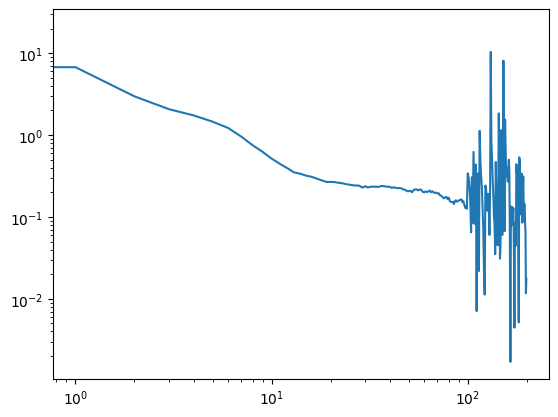

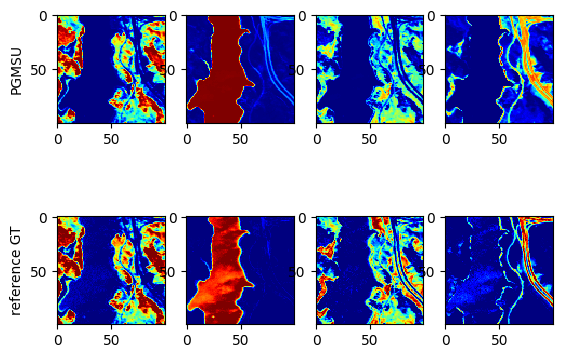

aRMSE:  0.08804278393513763


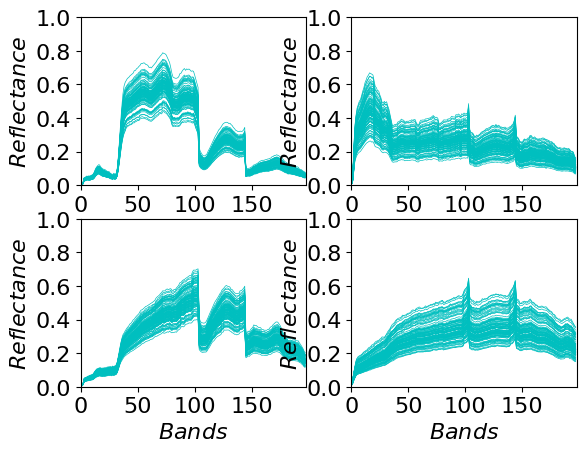

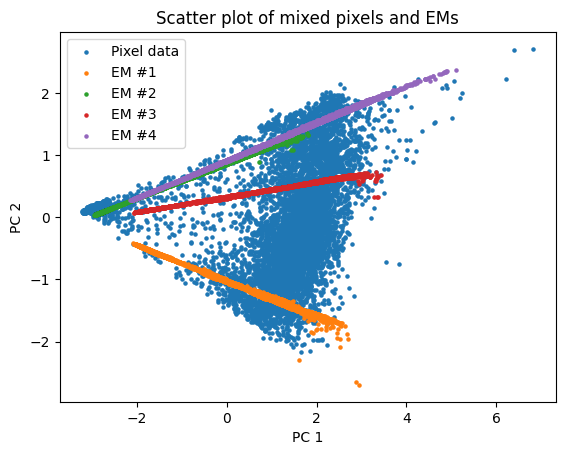

<ipython-input-54-58a93b7249ab>:111: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_weights))


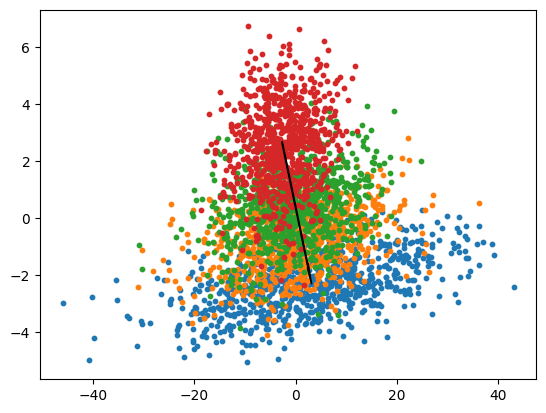

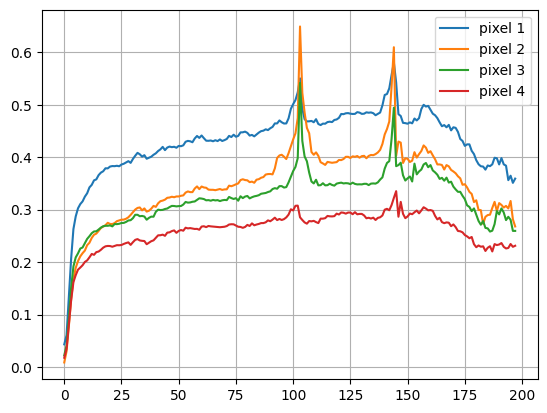

In [54]:
#test.py

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

cases = ['ex2', 'ridge']
case = cases[1]

model_weights = '/content/drive/MyDrive/PGMSU_weight/'
model_weights += 'PGMSU.pt'

output_path = '/content/drive/MyDrive/PGMSU_out/'
Y, A_true, P = loadhsi(case)

if case == 'ridge':
    nCol = 100
    nRow = 100
elif case == 'urban':
    nCol = 307
    nRow = 307
elif case == 'ex2':
    nCol = 50
    nRow = 50

nband = Y.shape[0]
N = Y.shape[1]
Channel = Y.shape[0]
z_dim = 4
##########################################################
# plot 1: trainging loss
loss = scio.loadmat(output_path + 'loss.mat')['loss']
plt.loglog(loss[0])
# plt.savefig(output_path+'loss.png')
plt.show()
##########################################################
EM_hat = scio.loadmat(output_path + 'results.mat')['EM']
A_hat = scio.loadmat(output_path + 'results.mat')['A']
Y_hat = scio.loadmat(output_path + 'results.mat')['Y_hat']


A_hat = np.reshape(A_hat, (nRow, nCol, P))
B = np.zeros((P, nRow, nCol))
for i in range(P):
    B[i] = A_hat[:, :, i]
A_hat = B
A_true = A_true.reshape([P, -1])
A_hat = A_hat.reshape([P, -1])

A_true = A_true.reshape([P, nCol, nRow])
A_hat = A_hat.reshape([P, nCol, nRow])

# plot 2 : Abundance maps
fig = plt.figure()
for i in range(1, P + 1):
    plt.subplot(2, P, i + P)
    aaa = plt.imshow(A_true[i - 1], cmap='jet', interpolation='none')
    # plt.axis('off')

    aaa.set_clim(vmin=0, vmax=1)
    plt.subplot(2, P, i)
    aaa = plt.imshow(A_hat[i - 1], cmap='jet',
                     interpolation='none')
    aaa.set_clim(vmin=0, vmax=1)
    # plt.axis('off')
plt.subplot(2, P, 1)
plt.ylabel('PGMSU')
plt.subplot(2, P, 1 + P)
plt.ylabel('reference GT')
plt.show()

plt.figure()
for i in range(P):
    plt.subplot(2, (P + 1) // 2, i + 1)
    plt.plot(EM_hat[0:EM_hat.shape[0]: 100, i, :].T, 'c', linewidth=0.5)
    plt.xlabel('$\it{Bands}$', fontdict={'fontsize': 16})
    plt.ylabel('$\it{Reflectance}$', fontdict={'fontsize': 16})
    plt.axis([0, len(EM_hat[0, i, :]), 0, 1])
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    # plt.axis('off')

armse = np.mean(np.sqrt(np.mean((A_hat - A_true) ** 2, axis=0)))
print('aRMSE: ', armse)



from sklearn.decomposition import PCA

pca1 = PCA(2)
y2d = pca1.fit_transform(Y.T)
plt.figure()
plt.scatter(y2d[:, 0], y2d[:, 1], 5, label='Pixel data')
P = EM_hat.shape[1]

for i in range(P):
    em2d = pca1.transform(np.squeeze(EM_hat[:, i, :]))
    plt.scatter(em2d[:, 0], em2d[:, 1], 5, label='EM #' + str(i + 1))

plt.legend()
plt.title('Scatter plot of mixed pixels and EMs')
# plt.savefig('em2d')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()




if case =='ridge':
    # generate new EMs
    model = PGMSU(P, Channel, z_dim).to(device)
    model.load_state_dict(torch.load(model_weights))
    model.eval()

    data = scio.loadmat('/content/drive/MyDrive/dataset/road4.mat')['road4']
    data = data.T.astype(np.float32)
    data = torch.from_numpy(data)

    num_pixels = 4
    repeat = 800
    Z = []
    for i in range(repeat):
        with torch.no_grad():
            y_hat, mu, log_var, a, em_tensor = model(data.to(device))
            z = model.reparameterize(mu, log_var)
        Z.append(z.cpu().numpy())
    Z = np.concatenate(Z, axis=0)
    # print(np.max(Z), np.min(Z))
    scio.savemat(output_path+'./Z.mat', {'z2d': Z})
    ################################
    # generate new endmembers
    EM_interp = []
    z_interp_ = []
    for t in np.arange(0, 8):
        z_interp_.append(t / 8 * mu[2, :] + (1 - t) / 8 * mu[3, :])
    for t in np.arange(0, 4):
        z_interp_.append(t / 4 * mu[0, :] + (1 - t) / 4 * mu[2, :])

    for t in np.arange(0, 8):
        z_interp_.append(t / 8 * mu[1, :] + (1 - t) / 8 * mu[0, :])

    for z_interp in z_interp_:
        with torch.no_grad():
            em_interp = model.decoder(z_interp.reshape(1, -1))
            em_interp = torch.reshape(em_interp, [-1, P, Channel])
            EM_interp.append(em_interp.cpu().numpy())
    EM_interp = np.concatenate(EM_interp, axis=0)

    scio.savemat(output_path+'./EM_interp.mat', {'EM_interp': EM_interp})
    ################################
    from sklearn.decomposition import PCA
    pca1 = PCA(2)
    z2d = pca1.fit_transform(Z)
    mu = pca1.transform(mu.cpu().numpy())
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    for i in range(4):
        plt.scatter(z2d[i:repeat * num_pixels:num_pixels, 0], z2d[i:repeat * num_pixels:num_pixels, 1], 10)
    ax.arrow(mu[3, 0], mu[3, 1], mu[0, 0] - mu[3, 0], mu[0, 1] - mu[3, 1],
             width=0.1,
             length_includes_head=True,
             head_width=0.25,
             head_length=1,
             fc='k',
             ec='k')
    plt.show()

    scio.savemat(output_path+'./z2d.mat', {'z2d': z2d})


    plt.plot(data.numpy().T)
    plt.grid('on')
    plt.legend(['pixel 1', 'pixel 2', 'pixel 3', 'pixel 4'])
    plt.show()
